## Overview of Q-learning algorithm 
Q-learning is a model-free reinforcement learning algorithm to learn quality of actions telling an agent what action to take under what circumstances. It does not require a model of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations.

## Probelm Representation
* The agent is in a grid world where each cell is a state and it has to reach the terminal state.
* The agent can move in four directions (The actions): North, South, East, and West.
* The agent receives a reward of -0.05 for each step taken except for obstacles. It receives either +1 or -1 when it reaches the terminal states. 

## Q-learning Algorithm Main Steps
1. Initialize the Q-table with zeros.
2. Start exploring actions: For each state, select any one among all possible actions for the current state (S).
3. Travel to the next state (S') as a result of that action (a).
4. For all possible actions from the state (S') select the one with the highest Q-value.
5. Update Q-table values using the equation.
6. Set the next state as the current state.
7. If the goal state is reached, then end and repeat the process.

**Importing Necessary Dependencies**

In [1]:
import heading #contains the Q-learning algorithm
import mdp4e #contains the MDP environment and related functions
import matplotlib.pyplot as plt #to plot q values
import numpy as np #for efficient array operations
import copy #for deep copying the Q values from one agent to another

**The function below returns the sequential decision enviroment that obeys the Markov Decision Process (MDP) principles**

* The function intialises a GridMDP object using provided parameters and sets up the sequential decision environment for Markov Decision Process (MDP) using a grid representation, with specified probabilities for different movement directions (intended, left, right) and a discount factor for future rewards.

In [2]:
def sequential_decision_env(maps, terminals, gamma, intended, left, right):
    """
    Creates a sequential decision environment using a GridMDP.

    Args:
        maps (list of lists): A 2D list representing the grid map where each element is a state.
        terminals (list of tuples): A list of terminal states in the grid.
        gamma (float): The discount factor for future rewards.
        intended (float): The probability of moving in the intended direction.
        left (float): The probability of moving to the left of the intended direction.
        right (float): The probability of moving to the right of the intended direction.
        
    Returns:
        mdp4e.GridMDP: An instance of the GridMDP class initialized with the provided parameters.
    """

    return mdp4e.GridMDP(maps, terminals, gamma, intended, left, right)

**The function below returns the Q-learning agent that learns the optimal policy to maximize the expected cumulative reward**

* The function initializes a QLearningAgent object using provided parameters and sets up the Q-learning agent that interacts with the given sequential decision environment.

In [3]:
def q_agent(seq_dec_env, alpha=lambda n: 60./(59+n), Ne=50, Rplus=2):
    """
    Initializes a Q-learning agent for a sequential decision environment.

    Args:
        seq_dec_env (mdp4e.GridMDP): The sequential decision environment the agent will interact with.
        alpha (function, optional): The learning rate for the Q-learning algorithm. Default is 60/(59+n), where n is the number of times the agent has visited the state-action pair.
        Ne (int, optional): The exploration parameter (iteration limit), default is 50.
        Rplus (float, optional): The reward for unexplored actions, default is 2.

    Returns: 
        heading.QLearningAgent: An instance of the QLearningAgent class initialized with the provided parameters.
    """ 

    return heading.QLearningAgent(seq_dec_env, Ne, Rplus, alpha)

**The function below visualises Q values at different stages to inspect convergence of the algorithm over time**
* The plot_Q_values function extracts all unique actions and states from the Q_agent's Q-values,
        initializes a matrix to store these values, and fills the matrix with the Q-values.
        It then plots this matrix as a heatmap, with actions on the x-axis and states on the y-axis.
        The heatmap uses a color gradient to represent the magnitude of the Q-values.
        

In [4]:
def plot_Q_values(Q_agent, trial):
    """
    Plots the Q-values of a Q-learning agent as a heatmap.

    Args:
        Q_agent (heading.QLearningAgent): The Q-learning agent containing the Q-values.
        trial (int): The trial number to be displayed in the plot title.
    """

    #extract all unique actions and states 
    actions = [(0,1), (0,-1), (-1,0), (1,0)] #the possible actions in the order of North, South, West, East
    states = sorted(set(state for state, _ in Q_agent.Q.keys())) #the sorted set of unique possible states

    #initialise the matrix to store actions and states
    #initialise the matrix with negative infinity values to make sure that when the matrix is filled with actual Q values,
    #the corresponding cell of an obstacle state and a None action will be coloured in black in the plot
    q_value_matrix = np.full(shape=(len(states), len(actions)), fill_value=-np.inf) 

    #fill the matrix with Q values
    for i in range(len(states)):
        for j in range(len(actions)):
            state = states[i] #get the state
            action = actions[j] #get the action

            if action is None: #if the action is None, skip the iteration
                continue
            else:
                q_value_matrix[i,j] = Q_agent.Q.get((state, action)) #get the Q value for the state-action pair
    
    #plot the Q value matrix as a heatmap
    plt.figure(figsize=(5,5))
    plt.imshow(q_value_matrix, cmap='hot', interpolation='none') #plot the heatmap
    plt.colorbar() #add a colorbar to the plot
    plt.title(f'Q-values heatmap at trial {trial}') #set the title of the plot

    #set the x and y labels
    plt.xticks(ticks=np.arange(len(actions)), labels=['North', 'South', 'West', 'East'], rotation=90) 
    plt.yticks(ticks=np.arange(len(states)), labels=states)
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.show() #display the plot
    plt.close()  #close the figure to free up memory

**The function below computes the maximum difference between the Q-values of the current and previous iterations to check for convergence**

* This function tracks how the Q-values change as the algorithm runs over trials. As Q-learning converges, the Q-values should stabilise, meaning the changes between updates become smaller over time.

In [5]:
def track_max_q_val_diff(current_q_agent, previous_q_agent):
    """
    Tracks the maximum difference in Q-values between two Q-learning agents.

    Args:
        current_q_agent (heading.QLearningAgent): The current Q-learning agent.
        previous_q_agent (heading.QLearningAgent): The previous Q-learning agent.

    Returns:
        float: The absolute value of the maximum difference in Q-values between the two agents.
    """

    max_diff = 0 #initialise the maximum difference in Q-values
    
    for (state, action), Q_val in current_q_agent.Q.items(): #iterate through the Q-values of the current Q-learning agent
        if (state, action) in previous_q_agent.Q: #if the state-action pair is present in the previous Q-learning agent
            diff = abs(Q_val - previous_q_agent.Q[(state, action)]) #calculate the difference in Q-values
            max_diff = max(max_diff, diff) #update the maximum difference in Q-values

    return max_diff

**The function below returns the formulated Q table after the Q-learning agent has explored the environment after 'trials' times. Additionally it visualises the Q value changes with a specified interval and finally plots the maximum difference between Q values in spaced out updates to visualise the convergence process**

* The agent interacts with the environment for 'trials' times and updates the Q table using the Q-learning algorithm. 'trials' is a sort of hyperparameter that can be tuned to make sure the optimal policy is learned by giving the agent ample opportunity to explore the environement. 
* After the agent has explored the environment for 'trials' times, the Q table is returned. It is a defaultdict object that maps state-action pairs to the expected cumulative reward that the agent can achieve by taking that action in that state, followed by following the optimal policy thereafter (Q values).

In [6]:
def Q_learning_result(q_agent, seq_dec_env, trials, plot_interval):
    """
    Runs the Q-learning algorithm for a specified number of trials. and tracks the maximum difference in Q-values 
    between consecutive Q-learning agents. Additionally, plots the Q-value heatmaps at specified intervals and a plot of
    the maximum difference in Q-values between consecutive Q-learning agents.

    Args:
        q_agent (heading.QLearningAgent): The Q-learning agent that will learn the optimal policy.
        seq_dec_env (mdp4e.GridMDP): The sequential decision environment the agent will interact with.
        trials (int): The number of trials the Q-learning algorithm will run.
        plot_interval (int, optional): The interval at which the Q values will be plotted. 

    Returns:
        defaultdict : A dictionary that maps state-action pairs to Q values (The Q table).
    """
    previous_q_agent = None #initialise the previous Q-learning agent
    max_diff_values = [0] #initialise the list to store the maximum difference in Q-values between two Q-learning agents

    for trial in range(trials): #runs the Q-learning algorithm for the specified number of trials
        heading.run_single_trial(q_agent, seq_dec_env) #runs a single trial of the Q-learning algorithm

        if trial % plot_interval == 0 and trial!=0: #if the trial number is a multiple of the plot interval and not the first trial
            plot_Q_values(q_agent, trial) #plots the Q values at the specified interval
        
        if previous_q_agent:
            max_diff = track_max_q_val_diff(q_agent, previous_q_agent) #calculates the maximum difference in Q-values between the current and previous Q-learning agents
            if trial % plot_interval == 0 and trial!=0: #if the trial number is a multiple of the plot interval and not the first trial
                max_diff_values.append(max_diff) #appends the maximum difference to the list

        #a deep copy is used here to ensure that the previous Q-learning agent is not updated when the current Q-learning agent is updated
        #(i.e. create a new object with the same values as the current Q-learning agent)
        previous_q_agent = copy.deepcopy(q_agent) #update the previous Q-learning agent with the current Q-learning agent

    #plot the maximum difference in Q-values between consecutive Q-learning agents
    plt.figure(figsize=(8,5))
    plt.plot(range(plot_interval, trials+1, plot_interval), max_diff_values) #plot the maximum difference in Q-values
    plt.xlabel('Trials') #set the x label of the plot
    plt.ylabel('Max Q-value Difference') #set the y label of the plot
    plt.title(f'Convergence of Q-Learning (Q-value changes over {trials} trials)') #set the title of the plot
    plt.show() #display the plot
    
    return q_agent.Q #returns the final Q table after the specified number of trials

**The main function below encapsulates the entire process of setting up the environment, training the agent, and visualising the Q-values**
* The agent is trained using the Q-learning algorithm by varying the values of the hyperparameters such as the gamma, intended, left, right probabilities, and the number of trials.
* The values were changed and experimented on, until the heatmaps showed that the agent has explored the environement enough to learn the optimal policy (When most cells show a bright colour, indicating high Q-values).

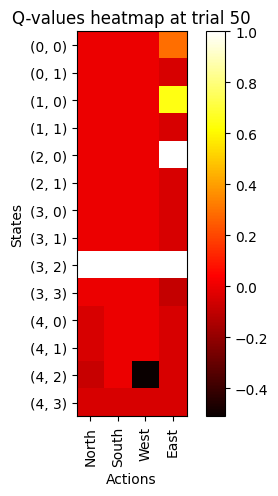

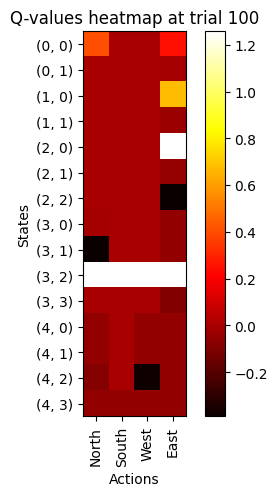

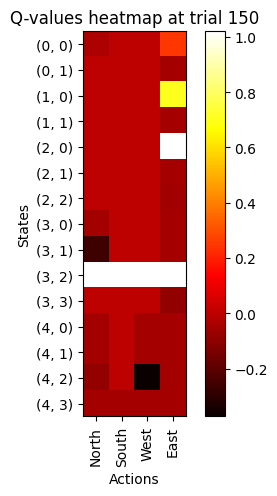

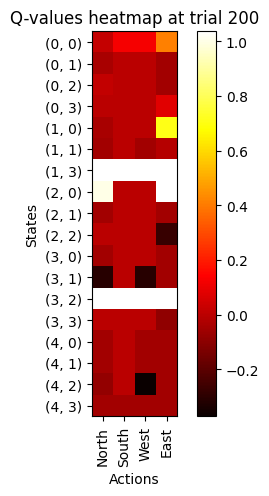

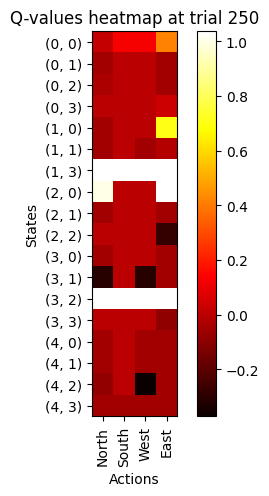

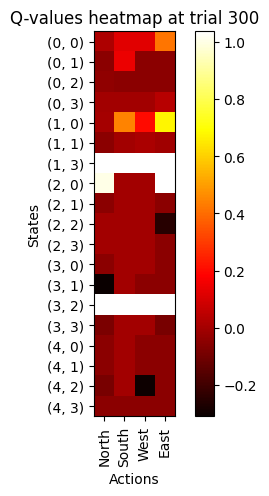

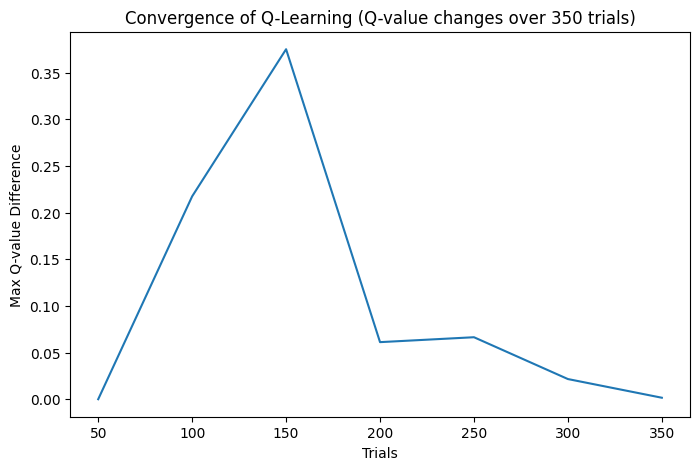


Q table after 350 trials:

dict_items([(((0, 0), (1, 0)), 1.191199392083947), (((0, 0), (0, 1)), 0.019774196100870847), (((0, 0), (-1, 0)), 0.12554526610163774), (((0, 0), (0, -1)), 0.12559603578473122), (((1, 0), (1, 0)), 1.891258972562981), (((1, 0), (0, 1)), 0.0032924836857478462), (((1, 0), (-1, 0)), 0.2041902489774212), (((1, 0), (0, -1)), 0.32300789116837386), (((2, 0), (1, 0)), 1.0361892823469763), (((2, 0), (0, 1)), 1.176011081917773), (((2, 0), (-1, 0)), 1.8161729954279875), (((2, 0), (0, -1)), 2.9602460169677216), (((3, 0), (1, 0)), -0.05), (((3, 0), (0, 1)), 0.1702070408240846), (((3, 0), (-1, 0)), 1.8570519420109555), (((3, 0), (0, -1)), 0.7914180631935768), (((4, 0), (1, 0)), -0.05), (((4, 0), (0, 1)), -0.05), (((4, 0), (-1, 0)), 1.137064404115631), (((4, 0), (0, -1)), 0.7979189875670566), (((4, 1), (1, 0)), -0.05), (((4, 1), (0, 1)), -0.05), (((4, 1), (-1, 0)), 0.2982828497057815), (((4, 1), (0, -1)), 0.37079769798938444), (((4, 2), (1, 0)), -0.05), (((4, 2), (0, 1)), -0

In [18]:
def main():
    #define the grid map
    R_s = -0.05
    maps = [[R_s, R_s, R_s, R_s, R_s],
            [R_s, None, R_s, -1, R_s],
            [R_s, R_s, R_s, R_s, R_s],
            [R_s, R_s, +1, R_s, R_s]]

    #define the terminal states
    terminals = [(3,2), (1,3)]

    #define the parameters for the sequential decision environment
    gamma = 0.7
    intended = 0.85
    left = 0.1
    right = 0.1

    #create the sequential decision environment
    seq_dec_env = sequential_decision_env(maps, terminals, gamma, intended, left, right)

    #define the Q-learning agent
    Q_agent = q_agent(seq_dec_env)

    #run the Q-learning algorithm 
    trials = 350
    plot_interval = 50
    Q_table = Q_learning_result(Q_agent, seq_dec_env, trials, plot_interval=plot_interval)

    #print the Q table
    print(f'\nQ table after {trials} trials:')
    print(f'\n{Q_table.items()}')

main()

***The final convergence plot above shows that the Q-learning algorithm has converged as the maximum difference between Q-values has become very small. This indicates that the Q-values have stabilised and the agent has learned the optimal policy.***